# CartPole (Inverse Pendulum)
We approach our first nonlinear system! I'm not sure if continuous CartPole admits a linearizing (with unlifted controls) and simplifying representation, but we shall see what our methods can do. One topic of interest will be to see whether we can break the symmetry of MSE costs by using time-delayed observations.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter
from extravaganza.utils import jkey, sample, SAMPLING_METHOD

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpltniwhcc
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpltniwhcc/_remote_module_non_scriptable.py


In [2]:
def run(observable, T0: int, reset_every: int, sysid_args):
    """
    fn to gather data and train a sysid.
    """
    # make system
    system = Gym(env_name='CartPoleContinuous-v1', repeat=3, max_episode_len=600)

    # make sysid
    sysid = Lifter(**sysid_args)
    system.reset_hook = lambda : sysid.end_trajectory()

    # interaction loop
    control = jnp.zeros(du)

    traj = Trajectory()
    for t in tqdm.trange(T0):
        if t % reset_every == 0: 
            system.reset()
            traj = Trajectory()
        cost, state = system.interact(control)
        traj.add_state(cost, state)
        obs = observable(traj)
        control = sysid.explore(cost, obs)
        traj.add_control(control)
        
    sysid.end_exploration(wordy=True)
    return system, sysid

In [3]:
def generate(observable, system, sysid, 
             N=1000, reset_every=10, hh=1, use_pbar=True):
    ds, du = system.state_dim, system.control_dim
    do, dl = sysid.obs_dim, sysid.state_dim
    
    states = []
    controls = []
    observations = []
    embeddings = []
    cost, obs, control = 0., jnp.zeros(do), jnp.zeros(du)
    if use_pbar: pbar = tqdm.tqdm(total=N)
    while len(embeddings) < N:
        if len(embeddings) % reset_every == 0:
            system.reset()
            traj = Trajectory()
        cost, state = system.interact(control)  # state will be `None` for unobservable systems
        traj.add_state(cost, state)
        obs = observable(traj)
        emb = sysid.get_state(obs, cost)
        control = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(control)
        
        states.append(state)
        controls.append(control)
        observations.append(obs)
        embeddings.append(emb)
        if use_pbar: pbar.update(1)
    if use_pbar: pbar.close()
        
    states, controls, observations, embeddings = map(lambda arr: jnp.stack(arr, axis=0), (states, controls, observations, embeddings))
    states, controls, observations, embeddings = states.reshape(N, ds), controls.reshape(N, du), observations.reshape(N, do), embeddings.reshape(N, dl)
    return states, controls, observations, embeddings

In [4]:
def print_prediction(observable, system, sysid, 
                     k=1, sampling_method='ball', hh=1):
    """
    See some prediction instances
    Here, 'original' means (f \circ g)(x_t), 'gt' means (f \circ g)(x_{t+k}), and 
        'pred' is the predicted embedding at t+k using linear dynamics given by (Ahat, Bhat).
    All norms are in the embedding space
    """
    Ahat, Bhat = sysid.A, sysid.B
    
    system.reset()
    done = False
    
    while not done:
        done = True
        
        traj = Trajectory()
        for _ in range(hh):
            u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
            traj.add_control(u)
            cost, x = system.interact(u)
            traj.add_state(cost, x)
            if system.done: done = False

        s = sysid.get_state(observable(traj), cost)
        original = s.copy()
        for _ in range(k):
            u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
            traj.add_control(u)
            cost, x = system.interact(u)
            traj.add_state(cost, x)
            s = Ahat @ s + Bhat @ u
            if system.done: done = False
        
    gt = sysid.get_state(observable(traj), cost)
    pred = s.copy()
    print(f'||gt - original||={jnp.linalg.norm(gt - original)}\t||pred - original||={jnp.linalg.norm(pred - original)}\t||gt - pred||={jnp.linalg.norm(gt - pred)}')
    pass

In [5]:
def plot(observable, system, sysid, 
         state_idx=2, obs_idx=2,
         N=2000, reset_every=10, hh=1):

    xs, us, os, zs = generate(observable, system, sysid, N=N, reset_every=reset_every, hh=hh)

    dl = zs.shape[1]
    fig, ax = plt.subplots(nrows=dl, ncols=2, figsize=(12, dl * 5))
    ax = ax.reshape(dl, 2)
    _xs, _os = xs[:, state_idx], os[:, obs_idx]
    for i in range(dl):
        _zs = zs[:, i]
        ax[i, 0].scatter(_xs, _os, color='r', label='obs(x)')
        ax[i, 0].scatter(_xs, _zs, s=4, color='b', label='emb(x)')
        ax[i, 1].scatter(_zs, _xs, color='c', label='x(emb)')
        ax[i, 1].scatter(_zs, _os, s=4, color='purple', label='obs(emb)')

        ax[i, 0].set_title('state space')
        ax[i, 0].set_xlabel('state')
        ax[i, 1].set_xlabel('emb_{}'.format(i))
        ax[i, 1].set_title('{}th coord of embedding space'.format(i))
        ax[i, 0].legend(); ax[i, 1].legend()
    plt.show()
    pass

# (1) Full Observation

In [6]:
# # dimensions
# ds, du = 4, 1
# dl = 1

# # define observation fn
# # observable = FullObservation(state_dim=ds)
# do = 1
# observable = Observable(obs_dim=do, obs_func=lambda traj: traj.x[-1][2:3])

# # send it
# T0 = 5000
# reset_every = int(1e9)
# exploration_args = {'scales': 0.5, 'avg_len': 5}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,
#     'state_dim': dl,

#     'exploration_args': {'random 0.8': exploration_args,
#                          'impulse 0.2': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'regression',
#     'deterministic': True,
#     'isometric': False,

#     'sigma': 0,
#     'depth': 3,
#     'num_iters': 12000,
#     'batch_size': 256,
#     'lifter_lr': 0.001,
    
#     'hh': 2,
# }
# system, sysid = run(observable, T0, reset_every, sysid_args)

In [7]:
# # check things
# if 'learned' in sysid.AB: sysid.A, sysid.B = sysid.AB['regression']
# print('\npredictions:')
# for _ in range(5):
#     print_prediction(observable, system, sysid, k=5, hh=3)

In [8]:
# plot(observable, system, sysid, N=2000, reset_every=reset_every, hh=3,
#     state_idx=2, obs_idx=0)

In [9]:
# xs, us, os, zs = generate(observable, system, sysid, N=5000, reset_every=500)
# diffs = os[1:] - os[:-1]
# dots = (diffs * us[:-1]).sum(axis=-1)
# plt.scatter(range(dots.shape[0]), dots)
# dots.mean()

# (2) Time-Delayed Costs & Controls

In [10]:
# dimensions
ds, du = 4, 1
dl = 2

# define observation fn
hh = 3
observable = TimeDelayedObservation(hh=hh, control_dim=du,
                                    use_controls=True, use_costs=True,
                                    use_states=False, use_cost_diffs=False, use_time=False)
do = observable.obs_dim

# send it
T0 = 5000
reset_every = int(1e9)
exploration_args = {'scales': 0.5, 'avg_len': 5}
sysid_args = {
    'obs_dim': do,
    'control_dim': du,
    'state_dim': dl,

    'exploration_args': {'random 0.8': exploration_args,
                         'impulse 0.2': exploration_args,
                        },

    'method': 'nn',
    'AB_method': 'learned',
    'deterministic': True,
    'isometric': False,
    
    'sigma': 0.01,
    'depth': 12,
    'num_iters': 32000,
    'batch_size': 512,
    'lifter_lr': 0.0008,
    
    'hh': hh,
}
system, sysid = run(observable, T0, reset_every, sysid_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.8 0.2]
100%|██████████████████████████████████████████████████████████████████████████████████

regression (ret) :
||A||_op = 0.4212396442890167
||B||_F = 2.23407244682312
||A-BK||_op = 0.09158126264810562
eig(A) = [0.13619033 0.06296229]
svd(B) = [2.2340724]

moments :
||A||_op = 0.24481749534606934
||B||_F = 0.3124459981918335
||A-BK||_op = 0.2227599024772644
eig(A) = [0.12422173 0.00122577]
svd(B) = [0.312446]

learned :
||A||_op = 0.13854925334453583
||B||_F = 2.25960373878479
||A-BK||_op = 0.1384441635228104
eig(A) = [0.13854925 0.13829301]
svd(B) = [2.2596037]



In [11]:
# check things
if 'learned' in sysid.AB: sysid.A, sysid.B = sysid.AB['learned']
print('\npredictions:')
for _ in range(5):
    print_prediction(observable, system, sysid, k=5, hh=3)


predictions:
||gt - original||=0.5858643054962158	||pred - original||=0.5995197296142578	||gt - pred||=0.013656140305101871
||gt - original||=0.10354874283075333	||pred - original||=0.08708891272544861	||gt - pred||=0.01646033488214016
||gt - original||=1.6515910625457764	||pred - original||=1.6565974950790405	||gt - pred||=0.005006286781281233
||gt - original||=1.0233954191207886	||pred - original||=1.0411298274993896	||gt - pred||=0.017734771594405174
||gt - original||=0.8188608884811401	||pred - original||=0.8116645812988281	||gt - pred||=0.0072016543708741665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1562.14it/s]


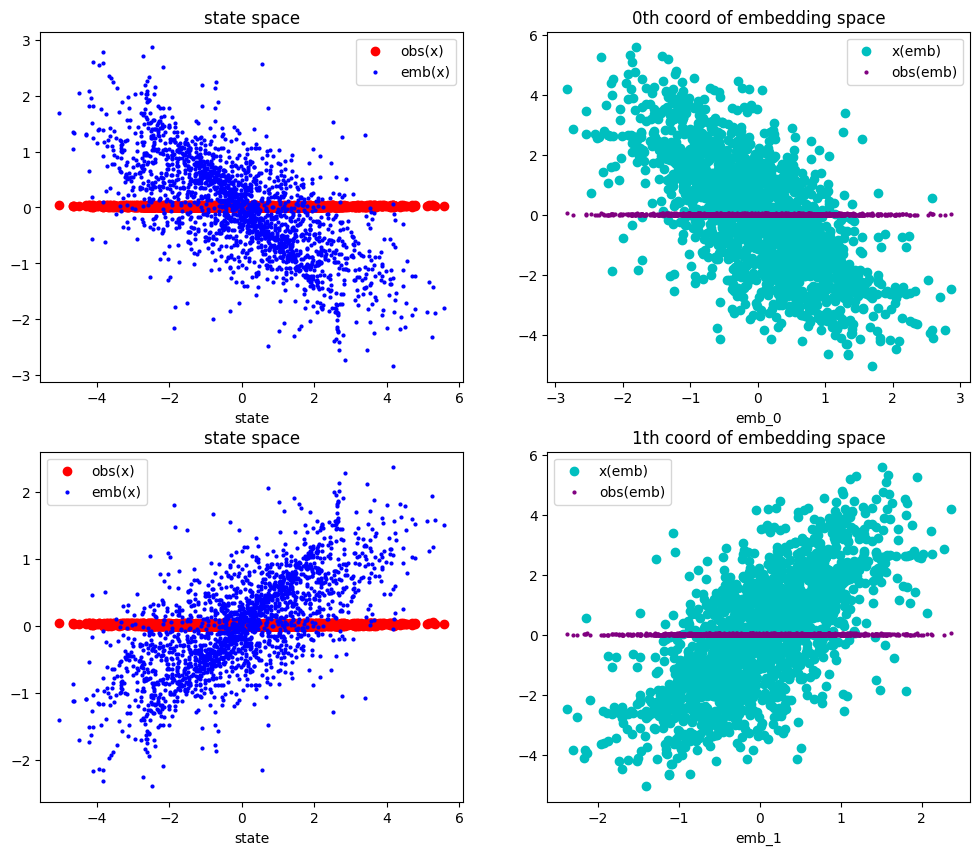

In [13]:
plot(observable, system, sysid, N=2000, reset_every=reset_every, hh=hh,
    state_idx=3, obs_idx=-1)